In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [48]:
df = pd.read_csv('steam_games_limpio.csv', encoding='utf-8')
# Convertir la columna "release_date" al tipo datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df.drop('Unnamed: 0', axis=1,inplace=True)

In [49]:
df['price'] = df['price'].apply(lambda x: '0' if isinstance(x, str) and not x.replace('.', '').isdigit() else x)

df['price'] = df['price'].astype(float)

eliminar = ['app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'id', 'developer', 'sentiment', 'metascore', 'publisher','publisher']
df2 = df.drop(eliminar, axis=1)
df2.dropna(inplace=True)
df2

,genres,price,early_access
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",4.99,False
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",0.00,False
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",0.00,False
3,"['Action', 'Adventure', 'Casual']",0.99,False
5,"['Action', 'Adventure', 'Simulation']",3.99,False
...,...,...,...
32050,"['Action', 'Adventure', 'Casual', 'Indie']",1.99,False
32051,"['Casual', 'Indie', 'Simulation', 'Strategy']",1.99,False
32052,"['Casual', 'Indie', 'Strategy']",4.99,False
32053,"['Indie', 'Racing', 'Simulation']",1.99,False


In [50]:
import ast

df2['genres'] = df2['genres'].apply(ast.literal_eval)

df2_exploded = df2.explode('genres')

df_dummies = pd.get_dummies(df2_exploded['genres'])

df_dummies['price'] = df2_exploded['price']
df_dummies['early_access'] = df2_exploded['early_access']

df_grouped = df_dummies.groupby(df_dummies.index).sum()

df_grouped['price'] = df2_exploded.groupby(df2_exploded.index).first()['price']
df_grouped['early_access'] = df2_exploded.groupby(df2_exploded.index).first()['early_access']

df2 = df_grouped

In [51]:
# Eliminar los registros que sean igual a 0 y la columna Free to Play

df2 = df2[df2['price'] != 0.00]
df2 = df2[df2['Free to Play'] != 1]
df2 = df2.drop('Free to Play', axis=1)

corregido = {'Animation &amp; Modeling': 'Animation & Modeling', 'Design &amp; Illustration': 'Design & Illustration'}
df2.rename(columns=corregido, inplace=True)
df2

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Education,Indie,...,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,price,early_access
0,0,1,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,4.99,False
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.99,False
5,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,3.99,False
12,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,10.99,False
13,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,3.99,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32050,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1.99,False
32051,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,1.99,False
32052,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,4.99,False
32053,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,1.99,False


In [52]:
df2.columns

Index(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration', 'Early Access',
       'Education', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG',
       'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Utilities', 'Video Production', 'Web Publishing', 'price',
       'early_access'],
      dtype='object')

In [53]:
# Definir las columnas que serán características en el modelo
X = df2.drop(columns=['price', 'Early Access'], axis=1)

y = df2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grado_polinomio = 1

# Crea el transformador polinomial
poly = PolynomialFeatures(degree=grado_polinomio)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

modelo_regresion = LinearRegression()

modelo_regresion.fit(X_train_poly, y_train)

y_pred = modelo_regresion.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

# Mostrar el RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 13.986997522594669


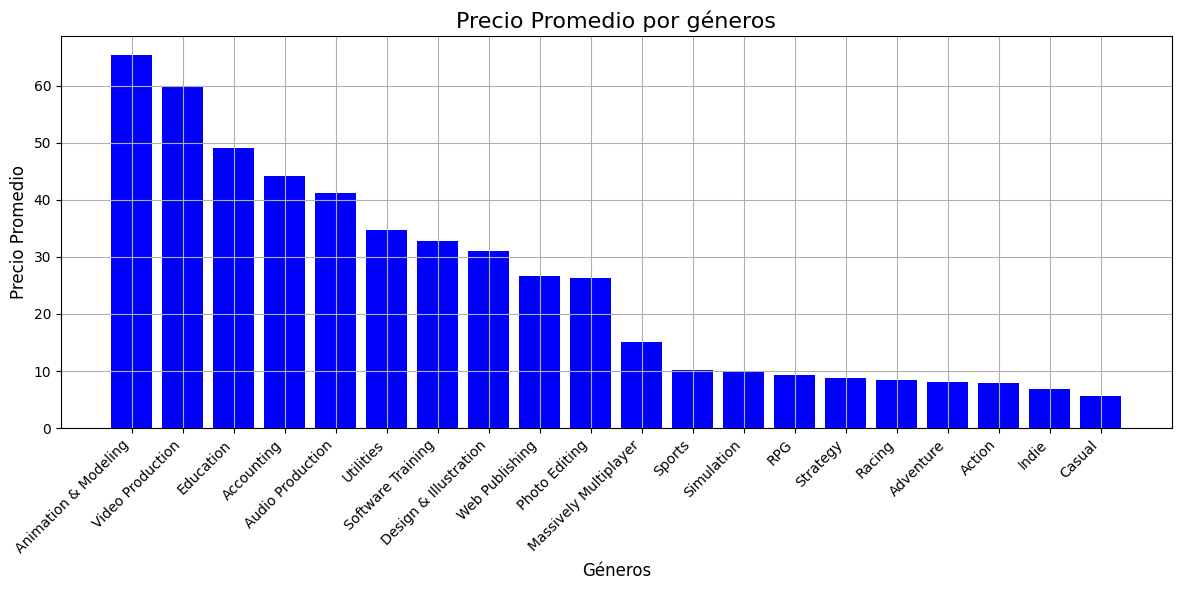

In [54]:
# Grafico para corroborar los precios de mi modelo

dummy_columns = ['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration',
       'Education', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG',
       'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Utilities', 'Video Production', 'Web Publishing'
       ]

mean_prices = []

for column in dummy_columns:
    filtered_df = df2[df2[column] == 1]
    mean_price = filtered_df['price'].mean()
    mean_prices.append(mean_price)

sorted_data = sorted(zip(dummy_columns, mean_prices), key=lambda x: x[1], reverse=True)
sorted_columns, sorted_mean_prices = zip(*sorted_data)

# Crear el gráfico de scatter plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_columns, sorted_mean_prices, color='blue')
plt.xlabel('Géneros', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)
plt.title('Precio Promedio por géneros', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

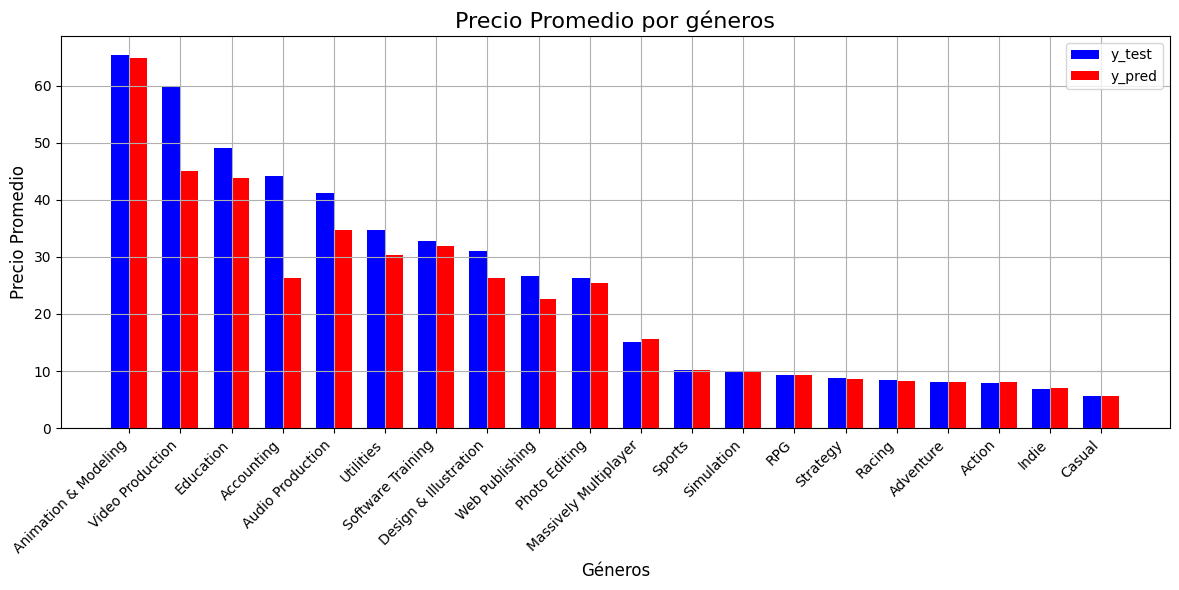

In [55]:
# Lista de columnas de variables dummy
dummy_columns = ['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration',
       'Education', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG',
       'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy',
       'Utilities', 'Video Production', 'Web Publishing'
       ]

mean_y_test = []
mean_y_pred = []

for column in dummy_columns:
    filtered_df = df2[df2[column] == 1]
    mean_y_test_genre = filtered_df['price'].mean()
    mean_y_pred_genre = y_pred[X_test.index.isin(filtered_df.index)].mean()
    mean_y_test.append(mean_y_test_genre)
    mean_y_pred.append(mean_y_pred_genre)

sorted_data = sorted(zip(dummy_columns, mean_y_test, mean_y_pred), key=lambda x: x[1], reverse=True)
sorted_columns, sorted_mean_y_test, sorted_mean_y_pred = zip(*sorted_data)

# Crear el gráfico de barras comparativo
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(sorted_columns))
plt.bar(index, sorted_mean_y_test, bar_width, color='blue', label='y_test')
plt.bar([i + bar_width for i in index], sorted_mean_y_pred, bar_width, color='red', label='y_pred')
plt.xlabel('Géneros', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)
plt.title('Precio Promedio por géneros', fontsize=16)
plt.xticks([i + bar_width/2 for i in index], sorted_columns, rotation=45, ha='right', fontsize=10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
import pickle
# Guardar el modelo, X_test_poly, y_test y y_pred en un archivo pkl
data_to_save = {'modelo': modelo_regresion, 'X_test_poly': X_test_poly, 'y_test': y_test, 'y_pred': y_pred, 'poly': poly, 'X': X}

with open('modelo_ml.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [57]:
def predecir_precio_y_rmse(generos, early_access):
    with open('modelo_ml.pkl', 'rb') as file:
        data = pickle.load(file)
    modelo_regresion = data['modelo']
    poly = data['poly']
    X_test_poly = data['X_test_poly']
    y_test = data['y_test']

    generos_a_predecir_df = pd.DataFrame({genero: [1 if genero in generos else 0] for genero in X.columns})

    generos_a_predecir_df['early_access'] = int(early_access)

    generos_a_predecir_poly = poly.transform(generos_a_predecir_df)

    precio_predicho = modelo_regresion.predict(generos_a_predecir_poly)[0]

    y_pred = modelo_regresion.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)

    rmse = np.sqrt(mse)

    return precio_predicho, rmse


# Ejemplo
generos_a_predecir = ['Adventure','Action', 'Indie', 'Racing']
early_access = True
precio_predicho, rmse = predecir_precio_y_rmse(generos_a_predecir, early_access)
print(f"Precio predicho: {round(precio_predicho, 2)}")
print(f"RMSE: {rmse}")

Precio predicho: 8.3
RMSE: 13.986997522594669


In [58]:
df2_filtrado = df2[(df2['Adventure'] != 0) & (df2['Action'] != 0) & (df2['Indie'] != 0) & (df2['Racing'] != 0)]
df2_filtrado['price'].mean()

5.80671052631579